# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow tensorflow-io matplotlib

Defaulting to user installation because normal site-packages is not writeable


## 1.2 Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

/Users/mohanganesh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [117]:
CAPUCHIN_FILE = '/Users/mohanganesh/Downloads/archive (1)/Parsed_Capuchinbird_Clips/XC98557-1.wav'
NOT_CAPUCHIN_FILE = '/Users/mohanganesh/Downloads/archive (1)/Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds-7.wav'

In [28]:
pip install torchaudio

Defaulting to user installation because normal site-packages is not writeable
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 22.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 40.5 MB/s eta 0:00:00
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Note: you may need to restart the kernel to use updated packages.


## 2.2 Build Dataloading Function

In [119]:
import tensorflow as tf
import torchaudio
import torch

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    
    # Convert TensorFlow tensor to numpy, then to PyTorch tensor
    wav = torch.tensor(wav.numpy())
    
    # Resample from original sample rate to 16kHz using torchaudio
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate.numpy(), new_freq=16000)
    wav = resampler(wav)
    
    return wav


## 2.3 Plot Wave

In [120]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

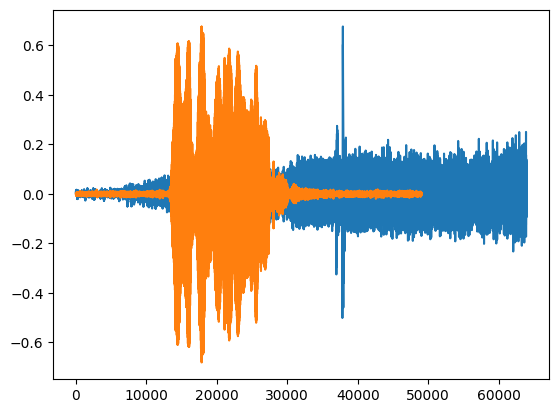

In [115]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [91]:
POS = os.path.join('/Users/mohanganesh/Downloads/archive (1)/Parsed_Capuchinbird_Clips')
NEG = os.path.join('/Users/mohanganesh/Downloads/archive (1)/Parsed_Not_Capuchinbird_Clips')


## 3.2 Create Tensorflow Datasets

In [92]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [93]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [94]:
lengths = []
for file in os.listdir(os.path.join('Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

Loaded Parsed_Capuchinbird_Clips/XC388470-3.wav, shape: (96000,)
Loaded Parsed_Capuchinbird_Clips/XC22397-2.wav, shape: (120000,)
Loaded Parsed_Capuchinbird_Clips/XC27881-0.wav, shape: (176400,)
Loaded Parsed_Capuchinbird_Clips/XC227469-0.wav, shape: (132300,)
Loaded Parsed_Capuchinbird_Clips/XC201990-1.wav, shape: (168000,)
Loaded Parsed_Capuchinbird_Clips/XC114132-3.wav, shape: (168000,)
Loaded Parsed_Capuchinbird_Clips/XC79965-2.wav, shape: (198450,)
Loaded Parsed_Capuchinbird_Clips/XC79965-3.wav, shape: (220500,)
Loaded Parsed_Capuchinbird_Clips/XC114132-2.wav, shape: (192000,)
Loaded Parsed_Capuchinbird_Clips/XC201990-0.wav, shape: (192000,)
Loaded Parsed_Capuchinbird_Clips/XC227469-1.wav, shape: (132300,)
Loaded Parsed_Capuchinbird_Clips/XC27881-1.wav, shape: (154350,)
Loaded Parsed_Capuchinbird_Clips/XC22397-3.wav, shape: (216000,)
Loaded Parsed_Capuchinbird_Clips/XC388470-2.wav, shape: (144000,)
Loaded Parsed_Capuchinbird_Clips/XC79965-10.wav, shape: (198450,)
Loaded Parsed_Cap

## 4.2 Calculate Mean, Min and Max

In [95]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=149905>

In [96]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=22050>

In [97]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=220500>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [106]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [107]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [108]:
spectrogram, label = preprocess(filepath, label)

AttributeError: 'bytes' object has no attribute 'numpy'

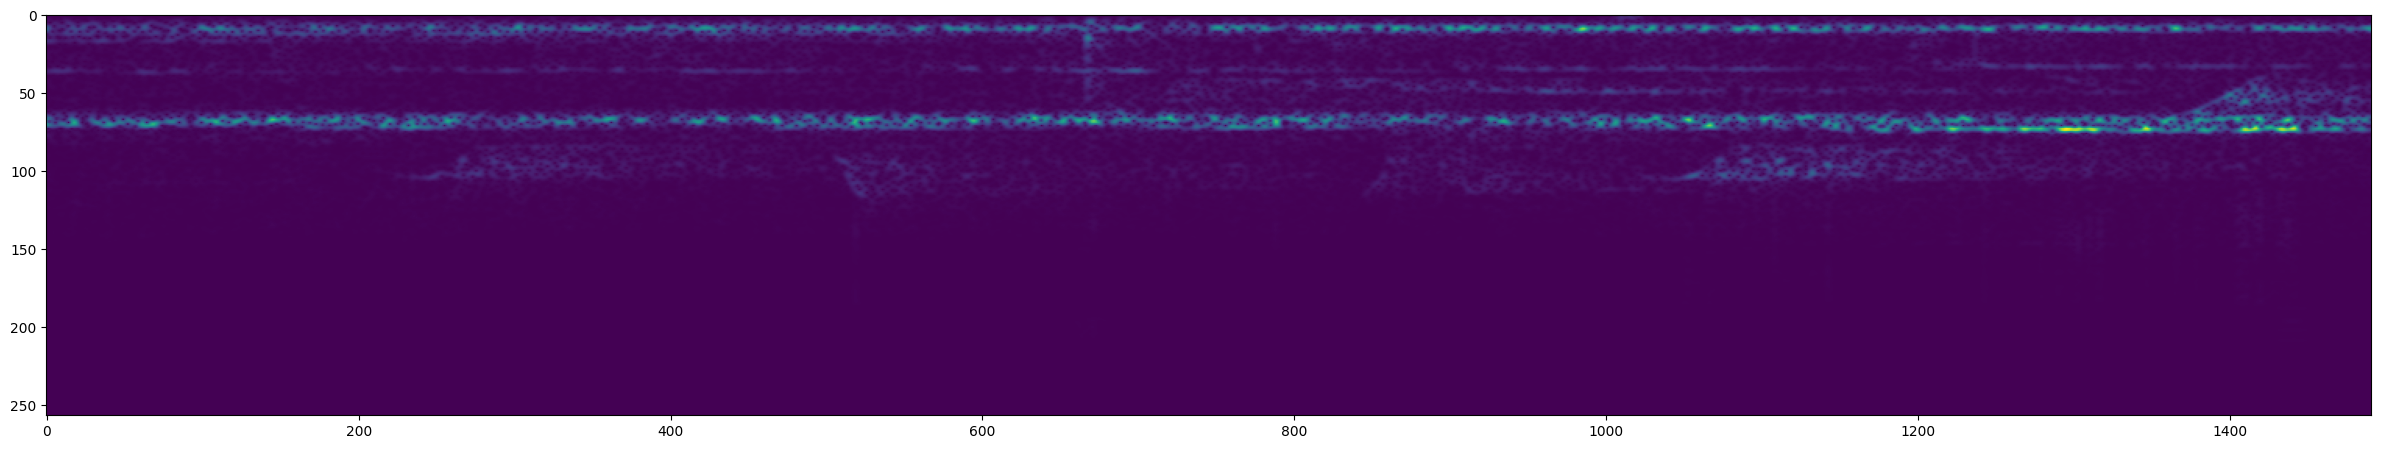

In [109]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [105]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Loaded Tensor("args_0:0", shape=(), dtype=string), shape: (None,)


ValueError: in user code:

    File "/var/folders/m7/xdpzc3ts3cs6p4yhplnr8fg40000gn/T/ipykernel_37585/643162278.py", line 2, in preprocess  *
        wav = load_wav_16k_mono(file_path)  # Load the WAV file
    File "/var/folders/m7/xdpzc3ts3cs6p4yhplnr8fg40000gn/T/ipykernel_37585/1334048134.py", line 19, in load_wav_16k_mono  *
        raise ValueError(f"The tensor for {filename} is scalar, unable to process.")

    ValueError: The tensor for Tensor("args_0:0", shape=(), dtype=string) is scalar, unable to process.


## 6.2 Split into Training and Testing Partitions

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

## 7.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])